# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [ ]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math # ADD for sqrt function __ Yiming

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.padding = padding

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size

        if isinstance(stride, int):
            self.stride = (stride, stride)
        else:
            self.stride = stride
            

        #Initialize weihgts
        k = math.sqrt(1 / (in_channels * self.kernel_size[0] * self.kernel_size[1]))
        self.w = torch.FloatTensor(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]).uniform_(-k, k)

        #Initialize bias
        if bias:
            self.b = torch.FloatTensor(out_channels).uniform_(-k, k)
        else:
            self.b = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        F, _C, _H, _W = self.w.shape

        HHHH = 1 + (H + 2 * self.padding - _H) // self.stride[0]
        WWWW = 1 + (H + 2 * self.padding - _W) // self.stride[1]

        x = nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        if self.b == None:
            x = (x.transpose(1, 2).matmul(self.w.view(F, -1).T)).transpose(1, 2)
        else:
            x = (x.transpose(1, 2).matmul(self.w.view(F, -1).T) + self.b).transpose(1, 2)
        out = nn.functional.fold(x, (HHHH, WWWW), kernel_size=(1,1)) 

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
            self.stride = (kernel_size, kernel_size)
        else:
            self.kernel_size = kernel_size
            self.stride = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        
        k_first , k_second = self.kernel_size
        HHHH = (H - k_first) // self.stride[0] + 1
        WWWW = (W - k_second) // self.stride[1] + 1

        y = F.unfold(x, kernel_size = self.kernel_size, stride=self.stride)
        out = torch.empty((N, C, y.shape[2]))
        for i in range(0, C):
            out[:, i, :] = y[:, i*k_first*k_second:(i+1)*k_first*k_second,:].max(dim=1)[0]
        out = F.fold(out, (HHHH, WWWW), kernel_size=(1,1))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.in_channels = in_channels
        self.out_channels = out_channels

        #Initialize weihgts
        k = math.sqrt(1 / in_channels) 
        self.weight = torch.FloatTensor(out_channels, in_channels).uniform_(-k, k)

        #Initialize bias
        if bias:
            self.bias = torch.FloatTensor(out_channels).uniform_(-k, k)
        else:
            self.bias = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, H = x.shape[0], x.shape[-1]

        if self.bias == None:
            out = x @ self.weight.T
        else:
            out = x @ self.weight.T + self.bias

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.num_features = num_features
        
        self.running_mean = torch.zeros(num_features)
        self.running_variance = torch.ones(num_features)

        self.eps = eps 

        self.momentum = momentum

        self.gamma = torch.ones(num_features)

        self.beta = torch.zeros(num_features)



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape

        mean = x.mean(axis=(0, 2, 3), keepdims=True)
        variance = ((x - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)

        if self.training:
            y = (x - mean) / torch.sqrt(self.eps + variance)
            self.running_mean = self.momentum * mean.squeeze() + (1.0 - self.momentum) * self.running_mean
            self.running_variance = self.momentum * variance.squeeze() + (1.0 - self.momentum) * self.running_variance
        else:
            y = (x - self.running_mean.reshape(1, self.num_features, 1, 1)) / torch.sqrt(self.eps + self.running_variance.reshape(1, self.num_features, 1, 1) )
        
        x = self.beta.reshape(1, self.num_features, 1, 1) + y * self.gamma.reshape(1, self.num_features, 1, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

Grid Search(GS) might be a prevalent and useful method for hyper-parameter searching. Its characteristic is brute force and effective because GS will try all the hyperparameters combination strategies and find the best hyperparameters set. But this also means that GS is very time-consuming.

With limited equipment resources and time, Random Search and Bayesian Optimization are good choices. Random Search (RS) randomly picks the point from the hyperparameter space, which means it is almost impossible for RS to select repeated hyperparameter combinations. Therefore, when the hyperparameter search space has a large dimension space, RS can try multiple hyperparameter combinations in
fewer iterations. Bayesian Optimization (BO) builds a probabilistic proxy model, which can predict the suitable values of hyperparameters in fewer iterations.

In this coursework, I try to use BO and RS for some hyperparameters searching. Although the search time was still long, it is much shorter than the cost of GS. With BO, the time cost is little, and the final accuracy is about 86%-89%. With Random Search, the time cost is slightly longer than BO, but the accuracy is about 89.5%-90.3%. With limited equipment resources and time, using Random Search is sufficient.

In [ ]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [ ]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    #update the __init__ input for hyper-parameter searching {Weight initialization methods, dropout)
    def __init__(self, ResidualBlock, weight_method, dropout, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,padding = 1, bias = False),
                       nn.BatchNorm2d(64), nn.ReLU())
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
        weight_method(self.conv1[0].weight)#hyper-parameter:Weight initialization methods
        self.drop = nn.Dropout2d(dropout)#hyper-parameter: dropout
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.drop(x) # dropout
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x

#update the input of ResNet18, for for hyper-parameter searching
def ResNet18(weight_method=nn.init.kaiming_uniform_, dropout=0.5):
    return ResNet(ResidualBlock, weight_method=weight_method, dropout=dropout)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

# Transform and Augment
transform_train= T.Compose([
                #T.RandomRotation(20),#maybe not good
                T.RandomCrop(size=32, padding=4),#might be helpful
                T.RandomHorizontalFlip(),#might be helpful
                T.ToTensor(),
                T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
            ])
transform_test = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
            ])

##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html).
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [ ]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

data_dir = './data'
batch_size = 64
#to train the final model
train_num = 50000

#to search hyper parameter
#train_num = 45000 

# Training data
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(train_num)))

# Validation data is just used for hyper_parameter searching.
#cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform_test)
#loader_val= DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(train_num, 50000)))

# Test data
cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform_test)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return (acc * 100) # add for Bayesian Optimization
        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """

    ####### add scheduler for better accuracy.
    milestones = [9, 10]
    gamma = 0.15 
    ####### there are some other methods like MultiStepLR. 
    ####### Such as: LambdaLR; StepLR; ExponentialLR; CosineAnnealingLR; ReduceLROnPlateau; CyclicLR. 
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma) # MultiStepLR, which is also a hyper-parameter, is one method to update the learning rate during the train process.

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()
        scheduler.step()
        ll = scheduler.get_last_lr()
        print("the newest learning rate is:")
        print(ll)# show the update process

In [ ]:
################## Bayesian Optimization( random search is better than this method. Random search is in later section)
!pip install gpy
!pip install gpyopt

     |████████████████████████████████| 1.0MB 8.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=d5ab22489ad34ac60ee78c71d3b543507b563819e9a82bea3f1e773f65c6a78a
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built gpy paramz
     |████████████████████████████████| 61kB 6.9MB/s 
  Created wheel for gpyopt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83623 sha256=54623188c4b7d23d1fbd3916c92f61e1ced4205969a5bae8fba922befe4659f9
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
Successfully built gpyopt


Random train batch: 15902-16902 Learning, Rate = 0.004530, Weight Decay = 0.007034
704
Epoch: 0, Iteration 0, loss = 3.8733

Epoch: 0, Iteration 100, loss = 2.4320

Epoch: 0, Iteration 200, loss = 2.0078

Epoch: 0, Iteration 300, loss = 1.8526

Epoch: 0, Iteration 400, loss = 1.8092

Epoch: 0, Iteration 500, loss = 1.8287

Epoch: 0, Iteration 600, loss = 1.7130

Epoch: 0, Iteration 700, loss = 1.5747

the newest learning rate is:
[0.00452966788719498]
704
Epoch: 1, Iteration 0, loss = 1.8361

Epoch: 1, Iteration 100, loss = 1.8025

Epoch: 1, Iteration 200, loss = 1.6434

Epoch: 1, Iteration 300, loss = 1.6032

Epoch: 1, Iteration 400, loss = 1.5425

Epoch: 1, Iteration 500, loss = 1.5992

Epoch: 1, Iteration 600, loss = 1.4440

Epoch: 1, Iteration 700, loss = 1.5052

the newest learning rate is:
[0.00452966788719498]
704
Epoch: 2, Iteration 0, loss = 1.5430

Epoch: 2, Iteration 100, loss = 1.6896

Epoch: 2, Iteration 200, loss = 1.4250

Epoch: 2, Iteration 300, loss = 1.7606

Epoch: 2,

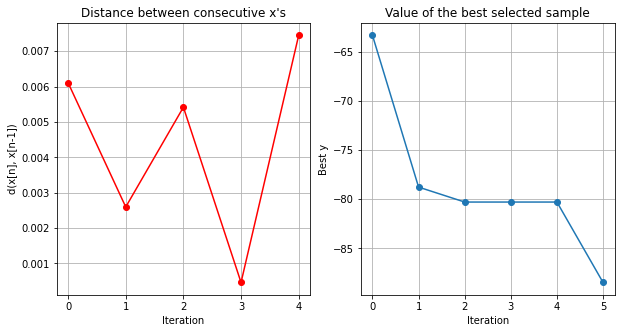

Best Hyperparameter with Learning Rate = 0.0002100, Weight Decay = 0.0000841, Accuracy: -88.46


In [ ]:
import GPy
import GPyOpt




weight_methods = [nn.init.kaiming_uniform_, 
          nn.init.kaiming_normal_,
          nn.init.xavier_uniform_, 
          nn.init.xavier_normal_]

dropout_rates = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6] 


def Bayesian_Optimization(paras):
    model = ResNet18(weight_method=weight_methods[0], dropout=dropout_rates[2])
    paras=paras.squeeze()
    optimizer = optim.Adam(model.parameters(),lr=paras[0],weight_decay=paras[1])
    random  = int(torch.rand(1)*40000)
    print("Random train batch: %d-%d Learning, Rate = %.6f, Weight Decay = %.6f"%(random,random+1000,paras[0],paras[1]))
#     loader_random = DataLoader(cifar10_train, batch_size=64, 
#                         sampler=sampler.SubsetRandomSampler(range(random, random+1000)))
    train_part(model,optimizer,epochs = 10)
    return check_accuracy(loader_val, model)
  
bounds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-5,1e-2)},
      {'name': 'weight_decay', 'type': 'continuous', 'domain': (1e-5,1e-2)}]
BO_test = GPyOpt.methods.BayesianOptimization(f = Bayesian_Optimization, # function to optimize       
                           domain=bounds,        # box-constraints of the problem
                           model_type = 'GP',
                           acquisition_type='EI',
                           maximize = True)
max_iter = 20    # evaluation budget
max_time = 60     # time budget 
eps = 10e-6  # Minimum allows distance between the las two observations

BO_test.run_optimization(max_iter, max_time,eps)
BO_test.plot_convergence()
learning_rate, weight_decay= BO_test.x_opt
print("Best Hyperparameter with Learning Rate = %.7f, Weight Decay = %.7f, Accuracy: %.2f"%(learning_rate,weight_decay,BO_test.fx_opt))

In [ ]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

#random search: according to the loss and accuracy, find the situable hyper-parameters.
#hyper-parameter:
#learning_rate, dropout_rate, weight_methods, optimizers, epochs, lr_scheduler method.

learning_rate = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

dropout_rates = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6]

epoch = [5,6,7,8,9,10]

weight_methods = [nn.init.kaiming_uniform_, 
          nn.init.kaiming_normal_,
          nn.init.xavier_uniform_, 
          nn.init.xavier_normal_]

model = ResNet18(weight_method=weight_methods[0], dropout=dropout_rates[2])

optimizers = [optim.Adam(model.parameters(),lr = learning_rate[4]),
        optim.RMSprop(model.parameters(),lr = learning_rate[4]),
        optim.SGD(model.parameters(),lr = learning_rate[4])]

#Grid search is too expensive and consuming. Random search and bayesian search is more efficient, but it cannot guaruntee that the final result is the best set of hyper-parameters.



##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network


train_part(model, optimizers[0], epochs = epoch[5])


# report test set accuracy

check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')

782
Epoch: 0, Iteration 0, loss = 4.3753

Epoch: 0, Iteration 100, loss = 1.6496

Epoch: 0, Iteration 200, loss = 1.6757

Epoch: 0, Iteration 300, loss = 1.5253

Epoch: 0, Iteration 400, loss = 1.5123

Epoch: 0, Iteration 500, loss = 1.3411

Epoch: 0, Iteration 600, loss = 1.2991

Epoch: 0, Iteration 700, loss = 1.3031

the newest learning rate is:
[0.001]
782
Epoch: 1, Iteration 0, loss = 1.1391

Epoch: 1, Iteration 100, loss = 1.1876

Epoch: 1, Iteration 200, loss = 1.0187

Epoch: 1, Iteration 300, loss = 1.0377

Epoch: 1, Iteration 400, loss = 0.9397

Epoch: 1, Iteration 500, loss = 0.7490

Epoch: 1, Iteration 600, loss = 0.9257

Epoch: 1, Iteration 700, loss = 0.6954

the newest learning rate is:
[0.001]
782
Epoch: 2, Iteration 0, loss = 0.7964

Epoch: 2, Iteration 100, loss = 0.7817

Epoch: 2, Iteration 200, loss = 1.0372

Epoch: 2, Iteration 300, loss = 0.6928

Epoch: 2, Iteration 400, loss = 0.5160

Epoch: 2, Iteration 500, loss = 0.7519

Epoch: 2, Iteration 600, loss = 0.8108



**The final accuracy is 90% for this model.(89%-90.3%)**

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

**<1>** **First Q**

For low-level layers, some simple structures are encoded after the convolution. Some features (such as contour, line, corners, edges, curves, etc.) and some high-intensity regions can be recognized in the network's first layers. 


From low-level layers to deeper layers, the layers build on top of each other and try to encode more complex, abstract patterns and objects built on top of those features extracted from the low-level layers. For deeper layers, the content of the pictures is difficult to recognize through the feature maps.


**<2>** **Second Q**


I think that the performance of my coursework is not sufficient good. Using random search, I get a set of hyperparameters, and the accuracy of the final model is always between 89%-90.3%, which is better than Bayesian Optimization. There are many different hyper-parameter combinations that I do not have enough time to use for training.

According to the training log, from the overall trend, loss shows a downward trend. But in one or two specific epochs, the loss has an upward trend, which is a nightmare for me. I think that the overfitting might happen due to some bad hyper-parameters in these epochs, such as epoch 7&8 in the training log.

Some key hyper-parameters that I used during the coursework:

* (1) lr_scheduler. Before adding the lr_scheduler to my code, the model accuracy is about 86%-87%. The learning rate needs to be adjusted during the training process to make the model converge to the global optimal point. And MultiStepLR could help me to achieve that. There are many other methods, which might be better than MultiStepLR. Such as CosineAnnealingLR; ReduceLROnPlateau; CyclicLR.
* (2) Data Augmentation methods.
* (3) weight_methods: kaiming_uniform ; kaiming_normal ; xavier_uniform ; xavier_normal . I think kaiming_uniform might be the best.
Some ways to make the performance better:

* (1) more epochs.
* (2) more data for training.
* (3) more layers.
* (4) more time.
* (5) a better method for hyper-parameter searching.

**<3> Third Q**


* (1) Build confusion matrix and visualize it in the heat map, including true positives, false positives, true negatives, and false negatives for each class.
* (2) Calculate the precision, recall, and f-score. Comparing the precision and recall of each class to analyze the performance of the model.
* (3) Plot the trend charts for train loss and validation loss.
* (4) Analyse some specific processes. Such as epoch 7 and epoch 8. To discuss "Why the loss has an upward trend?"
* (5) Plot the learning rate, gradient, and other parameters during the training process. Analyze the trend for each parameter.

<Figure size 432x288 with 0 Axes>

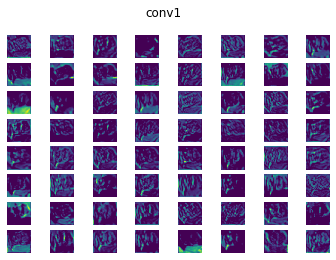

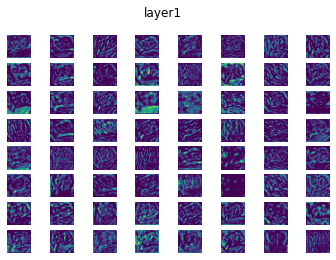

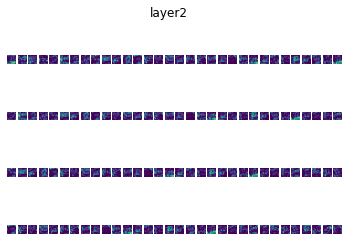

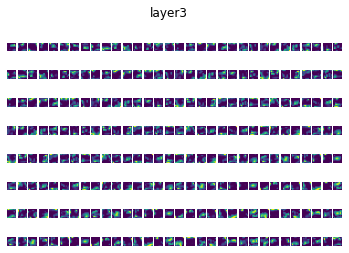

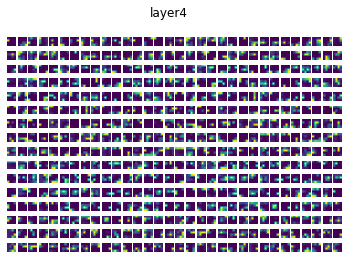

In [ ]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')